### Linear Assignment, the Hungarian algorithm.

Given a matrix where the element in the i-th row and j-th column represents the cost of assigning the j-th job to the i-th worker, find an assignment of the jobs to the workers, such that each job is assigned to one worker and each worker is assigned one job, such that the total cost of assignment is minimum.

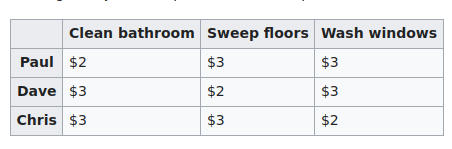

- The solution space is $O\left(n!\right)$ (all possible arrangements of $n$ columns).
- The Hungarian algorithm, also known as the Kuhn-Munkres algorithm (1955) solves this task in polynomial time $O\left(n^3\right)$.

- Tenim una sèrie de tasques i recursos, tasques = coses a fer, recursos = gent. 
- Asociat a això tenim un cost, els $ que hem de pagar.
- Per cada un d'ells tenim un cost asociat. 
- Asignació de tasques pel mínim possible -> chris -> natejar finestres. 
- Tasca d'assignar o minimitzar el cost de les accions. 
- ---
- n tasques i n recursos, tenim n factorial. Formes d'ordenar això. 
- problema de programació de n! és pitjor.
- n**2, (embeddings) -> ja es molt costos. 
- ---
- solució de n**3 -> reducció molt important

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### generate synthetic dataset

In [2]:
from sklearn.datasets import make_classification, make_regression

In [3]:
X, y = make_classification(n_samples=10000, n_features=10, n_informative = 5, n_classes = 10, n_clusters_per_class = 1, class_sep = 0.5, n_redundant = 0, random_state = 2783)
print(X.shape, y.shape)

(10000, 10) (10000,)


#### train/test split

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.2)

#### fit Gaussian-mixture model (GMM)

In [6]:
from sklearn.mixture import GaussianMixture

In [7]:
%time gm = GaussianMixture(n_components = 10, random_state = 0).fit(Xtrain)

CPU times: user 4.28 s, sys: 25.8 ms, total: 4.3 s
Wall time: 448 ms


In [8]:
Ypred = gm.predict(Xtest)

#### evaluation

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_fscore_support

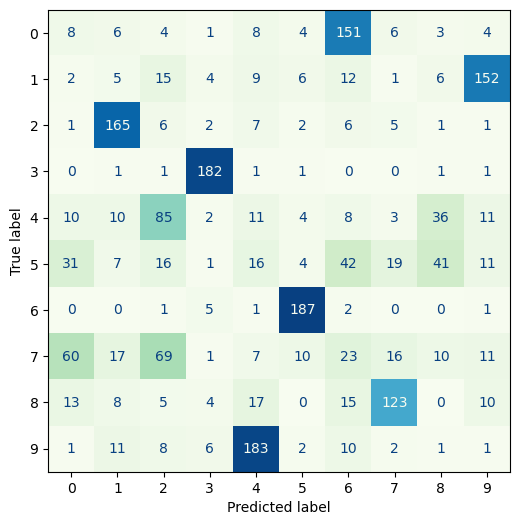

In [10]:
fig, axs = plt.subplots(1, 1, figsize = (6, 6))
ConfusionMatrixDisplay.from_predictions(
    Ytest,
    Ypred,
    normalize = None,
    ax = axs,
    cmap = 'GnBu',
    colorbar = False
);

**problem**: the predicted labels do not match the original labels !

### solve it as a linear assignment problem

In [11]:
from scipy.optimize import linear_sum_assignment

##### the Hungarian algorithm finds the assignment that minimizes the **trace** of the matrix
- the **trace** of a matrix is the sum of the diagonal
- ---
- El que busca es minimitzar els numeros que hi han a la diagonal perque la assignació de tasques sigui mínima. La traza trace es la suma d'element d'una diagonal.

In [12]:
m = confusion_matrix(Ytest, Ypred, normalize = None)

In [13]:
# trace suma elements de la diagonal
np.trace(m), np.sum([m[i, i] for i in range(m.shape[0])])

(235, 235)

- run the linear assignment algorithm

In [14]:
inputs, outputs = linear_sum_assignment(m)
inputs, outputs, 'cost = %3d' %np.sum(m[inputs, outputs])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([2, 7, 9, 6, 5, 3, 1, 4, 8, 0]),
 'cost =  19')

- change unmatched labels to matched labels

In [15]:
Ypred_matched = [np.where(outputs == y)[0] for y in Ypred]

- recompute the confusion matrix

In [16]:
m_matched = confusion_matrix(Ytest, Ypred_matched, normalize = None)

- display confusion matrices (unmatched and matched)

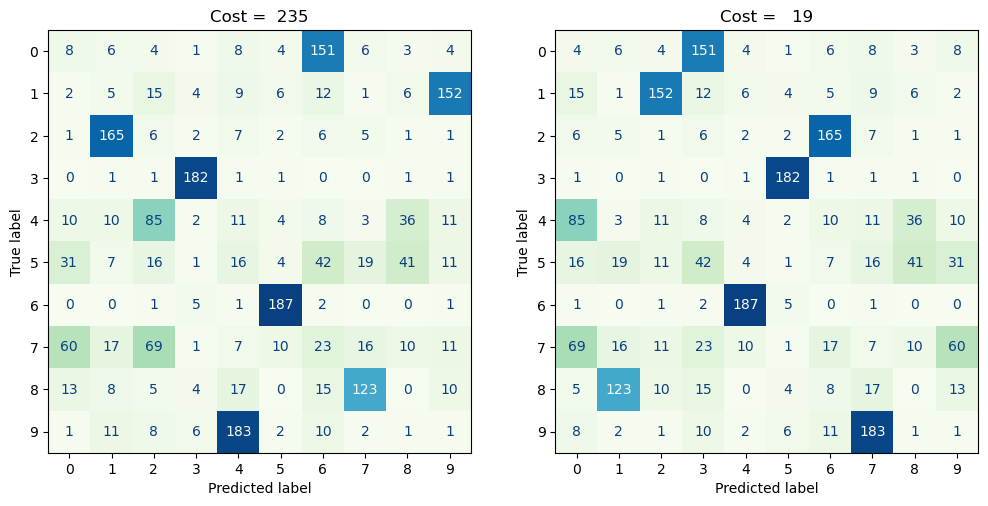

In [17]:
fig, axs = plt.subplots(1, 2, figsize = (12, 6))
# unmatched
ConfusionMatrixDisplay(m).plot(ax = axs[0], cmap = 'GnBu', colorbar = False)
axs[0].set_title('Cost = %4d' %np.trace(m))
# matched
ConfusionMatrixDisplay(m_matched).plot(ax = axs[1], cmap = 'GnBu', colorbar = False)
axs[1].set_title('Cost = %4d' %np.trace(m_matched));

#### we want to maximize the trace of the matrix !!!

- we can  use the Hungarian algorithm to find the assignment that ***Maximizes*** the trace of the matrix with a single trick
- subtract the maximum of the matrix
- ---
- volem els maxims a la diagonal en comptes dels mínims

In [18]:
m, m.max() -m

(array([[  8,   6,   4,   1,   8,   4, 151,   6,   3,   4],
        [  2,   5,  15,   4,   9,   6,  12,   1,   6, 152],
        [  1, 165,   6,   2,   7,   2,   6,   5,   1,   1],
        [  0,   1,   1, 182,   1,   1,   0,   0,   1,   1],
        [ 10,  10,  85,   2,  11,   4,   8,   3,  36,  11],
        [ 31,   7,  16,   1,  16,   4,  42,  19,  41,  11],
        [  0,   0,   1,   5,   1, 187,   2,   0,   0,   1],
        [ 60,  17,  69,   1,   7,  10,  23,  16,  10,  11],
        [ 13,   8,   5,   4,  17,   0,  15, 123,   0,  10],
        [  1,  11,   8,   6, 183,   2,  10,   2,   1,   1]]),
 array([[179, 181, 183, 186, 179, 183,  36, 181, 184, 183],
        [185, 182, 172, 183, 178, 181, 175, 186, 181,  35],
        [186,  22, 181, 185, 180, 185, 181, 182, 186, 186],
        [187, 186, 186,   5, 186, 186, 187, 187, 186, 186],
        [177, 177, 102, 185, 176, 183, 179, 184, 151, 176],
        [156, 180, 171, 186, 171, 183, 145, 168, 146, 176],
        [187, 187, 186, 182, 186,   0,

- run the linear assignment to minimize the trace of the modified matrix

In [19]:
inputs_max, outputs_max = linear_sum_assignment(m.max() -m)
inputs_max, outputs_max, 'Cost = %3d' %np.sum(m[inputs_max, outputs_max])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([6, 9, 1, 3, 2, 8, 5, 0, 7, 4]),
 'Cost = 1329')

- recompute the confusion matrix using the matching that maximizes the *trace*

In [20]:
Ypred_matched_max = [np.where(outputs_max == y)[0] for y in Ypred]

In [21]:
m_matched_max = confusion_matrix(Ytest, Ypred_matched_max, normalize = None)

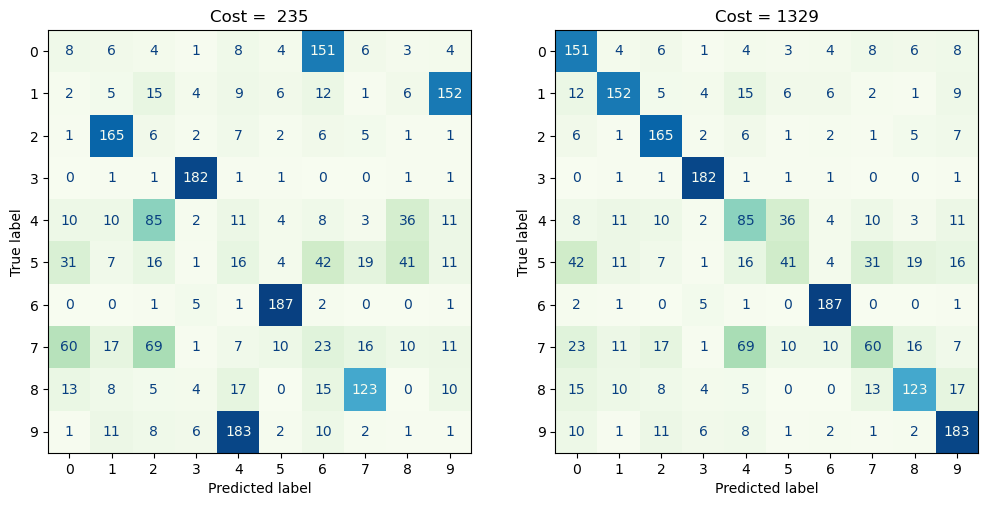

In [22]:
fig, axs = plt.subplots(1, 2, figsize = (12, 6))
# unmatched
ConfusionMatrixDisplay(m).plot(ax = axs[0], cmap = 'GnBu', colorbar = False)
axs[0].set_title('Cost = %4d' %np.trace(m))
# matched maximized
ConfusionMatrixDisplay(m_matched_max).plot(ax = axs[1], cmap = 'GnBu', colorbar = False)
axs[1].set_title('Cost = %4d' %np.trace(m_matched_max));